In [1]:
#pip install git+https://github.com/rcmalli/keras-vggface.git

In [1]:
#pip show keras-vggface

Name: keras-vggface
Version: 0.6
Summary: VGGFace implementation with Keras framework
Home-page: https://github.com/rcmalli/keras-vggface
Author: Refik Can MALLI
Author-email: mallir@itu.edu.tr
License: MIT
Location: c:\users\alber\anaconda3\envs\pythoncpu\lib\site-packages
Requires: keras, pillow, scipy, pyyaml, six, numpy, h5py
Required-by: 
Note: you may need to restart the kernel to use updated packages.


En esta notebook tratamos de abordar el problema aprovechando redes preentrenadas. Para ello utilizamos FaceNet preentrenada sobre MS-Celeb-1M (https://github.com/nyoki-mtl/keras-facenet). VGGFace ref (https://machinelearningmastery.com/how-to-perform-face-recognition-with-vggface2-convolutional-neural-network-in-keras/)

In [1]:
import os
import cv2
import time
import keras_vggface

import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from skimage.transform import resize
from keras.models import load_model
from keras_vggface.vggface import VGGFace
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
img_path = "./Data/"
#model_path = "./facenet_keras.h5"

img_size = 224

In [3]:
model=VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')

In [4]:
#model = tf.keras.models.load_model('VGGFace', compile=False)

In [5]:
model.summary()

Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________

## Calculamos los embeddings

En primer lugar, diseñamos la función que calculará la representación (embeddings) de nuestras imágenes.

In [6]:
def l2_normalize(x,axis=-1,epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

Utilizamos una SVM para predecir la clase correspondiente. Es importante escoger los hiperparámetros de la red con cuidado.

In [7]:
train_datagen = ImageDataGenerator(validation_split=0.1,horizontal_flip=True)
#batch_size = 128

train_generator = train_datagen.flow_from_directory(
    directory=r"./Data/train/",
    target_size=(img_size, img_size),
    color_mode="rgb",
    batch_size=311,
    class_mode="categorical",
    shuffle=False,
    subset = "training",
    seed=42
)

val_generator = train_datagen.flow_from_directory(
    directory=r"./Data/train/",
    target_size=(img_size, img_size),
    color_mode="rgb",
    batch_size=409,
    class_mode="categorical",
    shuffle=False,
    subset = "validation",
    seed=42
)

test_generator = train_datagen.flow_from_directory(
    directory=r"./Data/test/",
    target_size=(img_size, img_size),
    color_mode="rgb",
    batch_size=194,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

Found 25814 images belonging to 7 classes.
Found 2863 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [8]:
def calculate_embedding(generator, steps):
    print("Calculating embeddings in",steps,"steps")
    embs = l2_normalize(model.predict_generator(generator,steps=steps,verbose=1))
    return embs

In [10]:
'''
#Nos dejamos una imagen sin cargar
X_train = calculate_embedding(train_generator, 25813//311)
y_train = train_generator.classes[:len(X_train)]
print(X_train.shape)
print(y_train.shape)
'''

Calculating embeddings in 83 steps
83/83 [==============================] - 606s 7s/step
(25813, 2048)
(25813,)


In [9]:
'''
X_val = calculate_embedding(val_generator, 2863//409)
y_val = val_generator.classes[:len(X_val)]
print(X_val.shape, y_val.shape)
'''

Calculating embeddings in 7 steps
Instructions for updating:
Please use Model.predict, which supports generators.
7/7 [==============================] - 67s 10s/step
(2863, 2048) (2863,)


In [11]:
#DESCOMENTAR ESTA CELDA SI QUERÉIS VOLVER A CARGAR LAS IMÁGENES DE PRUEBA

'''
#steps=2868//batch_size
X_test = calculate_embedding(test_generator, 7178//194)
y_test = test_generator.classes
print(X_test.shape, y_test.shape)
'''

Calculating embeddings in 37 steps
37/37 [==============================] - 169s 5s/step
(7178, 2048) (7178,)


In [13]:
#Guardamos los datos tras calcular el embedding 
# Así no tenemos que calcularlos cada vez que ejecutemos el código
'''
import pickle

file = open('emb_data', 'wb')
pickle.dump(X_train, file)
pickle.dump(X_val, file)
pickle.dump(X_test, file)
pickle.dump(y_train, file)
pickle.dump(y_val, file)
pickle.dump(y_test, file)
file.close()
'''

## Entrenamiento de los clasificadores

En primer lugar, cargamos los datos ya pasados por el embedding

In [9]:
#SI YA HABÉIS PROCESADO Y CARGADO LAS IMÁGENES DE TEST, AQUÍ NO HAY QUE VOLVER A CARGARLAS. 
# Sin embargo, tendréis que volver a cargarlas en una lista auxiliar para que cada conjunto esté donde tiene que estar del fichero
# (aunque luego no hagáis nada con ellas)

#Cargamos la información
import pickle
file = open("emb_data", "rb")
X_train = pickle.load(file)
X_val = pickle.load(file)
X_test = pickle.load(file)
y_train = pickle.load(file)
y_val = pickle.load(file)
y_test = pickle.load(file)
file.close()

In [10]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(25813, 2048)
(2863, 2048)
(7178, 2048)


In [11]:
X_train = np.append(X_train, X_val)
X_train = np.reshape(X_train, (-1,2048))
y_train = np.append(y_train, y_val)

In [29]:
#Si queremos usar un Random Forest descomentamos esto
'''
import time
from sklearn.ensemble import RandomForestClassifier

start = time.time()
clf = RandomForestClassifier(max_depth = 25, max_features = 'auto', min_samples_split = 5, min_samples_leaf = 3, bootstrap = False, criterion = "gini", n_estimators = 2000, random_state = 27, n_jobs = -1)
print("Comenzando el entrenamiento")
clf.fit(X_train_def, y_train_def)
end = time.time()
print("Terminando el entrenamiento. Tiempo de entrenamiento: " ,end - start)
'''

Comenzando el entrenamiento
Terminando el entrenamiento. Tiempo de entrenamiento:  323.0040030479431


Para los clasificadores nos hemos basado en este código de StackOverflow: https://stackoverflow.com/questions/31681373/making-svm-run-faster-in-python

In [6]:
#Si queremos usar múltiples SVC pequeñas descomentamos esto
'''
import time
import numpy as np
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

n_estimators = 5

start = time.time()
clf = BaggingClassifier(SVC(kernel='rbf', C=10, probability=True), max_samples=int(len(X_train) * 0.5), bootstrap=False, n_estimators=n_estimators, random_state = 27, n_jobs = -1)
print("Comenzando el entrenamiento")
clf.fit(X_train, y_train)
end = time.time()
print("Terminando el entren amiento. Tiempo de entrenamiento: " ,end - start)
'''

Comenzando el entrenamiento
Terminando el entren amiento. Tiempo de entrenamiento:  6061.742595672607


In [25]:
#Si queremos usar una SVC descomentamos esto
'''
import time
import numpy as np
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC

start = time.time()
print("Comenzando el entrenamiento")

clf = SVC(kernel='rbf', C = 100, probability=True, verbose=1)
clf.fit(X_train_def, y_train_def)
end = time.time()
print("Terminando el entrenamiento. Tiempo de entrenamiento: " ,end - start)
'''

Comenzando el entrenamiento
[LibSVM]Terminando el entrenamiento. Tiempo de entrenamiento:  8962.938892364502


In [9]:
#Guardamos el modelo
#import pickle

#filename = 'SVM_Ensemble_67_68'
#pickle.dump(clf, open(filename, 'wb'))

## Cálculo de los resultados

In [12]:
#Cargamos el modelo, en caso de querer trabajar con un modelo preentrenado
import pickle

nombre_clasificador = 'SVM_68_93'
clf = pickle.load(open(nombre_clasificador, 'rb'))

In [13]:
start = time.time()
print("Validación")
print ("Precisión: ", clf.score(X_val, y_val))
end = time.time()
print("Tiempo de predicción: ", end - start)

Validación
Precisión:  0.9961578763534754
Tiempo de predicción:  116.88139939308167


In [14]:
start = time.time()
print("Test")
print ("Precisión: ", clf.score(X_test, y_test))
end = time.time()
print("Tiempo de predicción: ", end - start)
print("Tiempo de predicción por fotografía: ", (end - start)/len(X_test))

Test
Precisión:  0.6893285037614935
Tiempo de predicción:  290.2859435081482
Tiempo de predicción por fotografía:  0.04044106206577713


In [15]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def print_cmx(y_true, y_pred, cmap=plt.cm.Blues):
    """
    The function is used to construct the confusion matrix 
    """
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(6,6))
    mpl.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix) 
    for i in range(0,7):
        for j in range(0,7):  
            ax.text(j,i,cm[i,j],va='center', ha='center')
    labels = ['angry', 'disgust','fear', 'happy', 'neutral','sad', 'surprise']
    ticks = np.arange(len(labels))
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           0       0.60      0.62      0.61       958
           1       0.92      0.64      0.76       111
           2       0.57      0.50      0.53      1024
           3       0.84      0.88      0.86      1774
           4       0.65      0.67      0.66      1233
           5       0.57      0.58      0.58      1247
           6       0.81      0.78      0.80       831

    accuracy                           0.69      7178
   macro avg       0.71      0.67      0.68      7178
weighted avg       0.69      0.69      0.69      7178

Accuracy: 0.6893285037614935


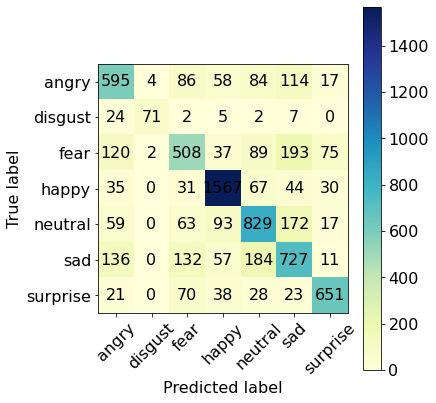

In [16]:
import matplotlib as mpl

#y_test = Y_test.reshape(Y_test.shape[0],)

y_test_predicted = clf.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print_cmx(y_test, y_test_predicted, cmap=plt.cm.YlGnBu)
print(classification_report(y_test, y_test_predicted))
print("Accuracy: {0}".format(accuracy_score(y_test, y_test_predicted)))

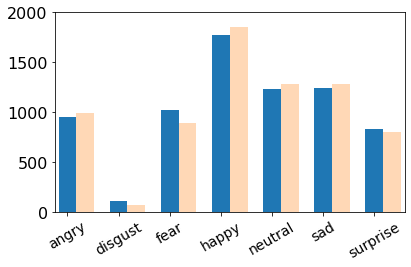

In [17]:
int_y_test_predicted = [int(res) for res in y_test_predicted]
int_y_test_true = [int(res) for res in y_test]

def plot_distribution2(y_true, y_pred):
    """
    The function is used to compare the number of true labels as well as prediction results
    """
    #colorset = Dark2_7.get_mpl_colormap() #brewer2mpl.get_map('Set3', 'qualitative', 6).mpl_colors
    ind = np.arange(1.5,8,1)  # the x locations for the groups
    width = 0.35   
    fig, ax = plt.subplots()
    true = ax.bar(ind, np.bincount(y_true), width, alpha=1.0)
    pred = ax.bar(ind + width, np.bincount(y_pred), width, alpha=0.3)
    ax.set_xticks(np.arange(1.5,8,1))
    labels = ['angry', 'disgust','fear', 'happy', 'neutral','sad', 'surprise']
    ax.set_xticklabels(labels, rotation=30, fontsize=14)
    ax.set_xlim([1.25, 8.1])
    ax.set_ylim([0, 2000])
    ax.set_title('')
    plt.tight_layout()
    plt.show()
    
plot_distribution2(int_y_test_true, int_y_test_predicted)